## Image2Pipeline   (MIRI CALIMAGE2)

`Image2Pipeline` applies instrumental corrections and calibrations, in addition to the subtraction of dedicated background exposures, that result in a fully calibrated, background subtracted individual exposures. 

Official documentation for `Image2Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html>

The `Image2Pipeline` comprises a linear series of steps. The steps applied to MIRI data in order are:

|Step|Description|
|:---|:---|
|`background`|subtract dedicated background exposures|
|`assign_wcs`|attach WCS object to each science exposure|
|`flat_field`|correct the exposure using the flat-field reference file|
|`photom`|apply flux (photometric) calibration|
|`resample`|resample using WCS and distortion information into an undistorted product|


For more information and examples of each of the steps click on the links in the side bar.

### Input data

An example of running the file through the `Image2Pipeline` is now shown using a simple simulated 4-point dither observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1) and brought to level 2A using the `Detector1Pipeline`. A background observation is also associated to the science exposures for subtraction.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

`Image2Pipeline` can be run by passing indivual exposures or datamodels but in this sample case we produce an association file that links the background exposures to the science exposures so it can be subtracted. It is assumed that the science files are in 'IMA_science' and the background file is in 'IMA_background'. The content of the association file is printed for inspection.

In [2]:
# load the science and background files to lists
my_science_files = glob.glob('IMA_science/*rate.fits')
my_background_files = glob.glob('IMA_background/*rate.fits')
my_science_files = sorted(my_science_files)

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, rule=DMSLevel2bBase)
asn.data['products'] = None

# set the association name
asn_name = 'my_galaxy'

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'image2'

for n, sci in enumerate(my_science_files):
    asn.new_product('{}_dither{}'.format(asn_name, str(n+1)))
    sci_member = Member({'expname': sci, 'exptype': 'science'})    
    new_members = asn.current_product['members']
    new_members.append(sci_member)
    
    for bkg in my_background_files:
        bkg_member = Member({'expname': bkg, 'exptype': 'background'})
        new_members.append(bkg_member)
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl2_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "products": [
        {
            "name": "my_galaxy_dither1",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        },
        {
            "name": "my_galaxy_dither2",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1

Import Image2Pipeline and print the docstring to show some information

In [3]:
from jwst.pipeline import Image2Pipeline
print(Image2Pipeline.__doc__)


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    background_subtraction, assign_wcs, flat_field, photom and resample.
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. 

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output
    
Note that the `Image2Pipeline` will return the level 2B datamodel for each exposure as a list of datamodels so we set these to `dm_cont`. The output filenames will be determined by the `asn_name` in the association file which was set in the cell above.


In [4]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
dm_cont = Image2Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir)


2019-07-22 15:48:54,270 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2019-07-22 15:48:54,272 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-07-22 15:48:54,274 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-07-22 15:48:54,276 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-07-22 15:48:54,277 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-07-22 15:48:54,279 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2019-07-22 15:48:54,322 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('my_galaxy_lvl2_asn.json',).
2019-07-22 15:48:54,790 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufor

2019-07-22 15:48:57,043 - stpipe.Image2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0004.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1705, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-07-22 15:48:57,063 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0004.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2019-07-22 15:4

2019-07-22 15:49:00,152 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-07-22 15:49:00,168 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0042.fits
2019-07-22 15:49:00,173 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0004.fits
2019-07-22 15:49:00,225 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2019-07-22 15:49:00,225 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2019-07-22 15:49:00,226 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2019-07-22 15:49:00,226 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2019-07-22 15:49:00,251 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2019-07-22 15:49:00,252 - stpipe.Image2Pipeline.photom - INFO -

2019-07-22 15:49:04,574 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2019-07-22 15:49:04,635 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-07-22 15:49:04,912 - stpipe.Image2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0028.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1705, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-07-22 15:49:04,922 - stpipe.Image2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0004.asdf' was created with extension 'asdf.exte

We can plot the before (rate) and after (cal) images for the first dither position

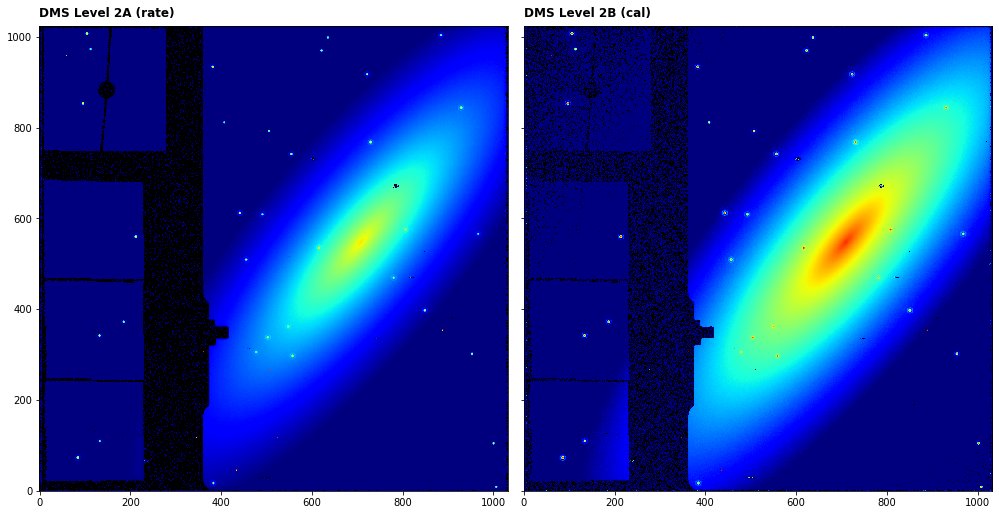

In [5]:
# open the input image as a jwst data model
with datamodels.open(my_science_files[0]) as in_dm:

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

    axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10, vmax=1000))
    axs[0].annotate('DMS Level 2A (rate)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm_cont[0].data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10, vmax=1000))
    axs[1].annotate('DMS Level 2B (cal)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    plt.tight_layout()
    plt.show()


### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_galaxy_lvl2_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "products": [
        {
            "name": "my_galaxy_dither1",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        },
        {
            "name": "my_galaxy_dither2",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        },
        {
            "name": "my_galaxy_dither3",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq3_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        },
        {
            "name": "my_galaxy_dither4",
            "members": [
                {
                    "expname": "IMA_science/det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_background/det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ],
    "asn_pool": "my_galaxy_pool"
}
```

**Option 1:**
Run the `Image2Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Image2Pipeline my_galaxy_lvl2_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Image2Pipeline` using the `strun` command with the associated `calwebb_image2.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_image2.cfg my_galaxy_lvl2_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*